# I'm a robot: Breaking Google ReCAPTCHA

## Introduction

The main purpose of a CAPTCHA system is to prevent automated system access by computer programs and other bots. There are various versions of CAPTCHA with distorted images as shown below:

[![CAPTCHAs.png](https://s18.postimg.org/4o0nc6bbt/CAPTCHAs.png)](https://postimg.org/image/v9367qdp1/)

Google has been actively trying to prevent robots from breaking their systems, and their reCAPTACHA system has gained wide popularity all over the world. Hence, we are particularly interested in the reCAPTCHA system in this project. ReCAPTCHA currently features a "I am not a robot" check box, and we may pass the check even without solving a puzzle. Behind this checkbox is a risk analysis engine, and robots need to behave like a human to cheat this engine.

[![Not_a_robot.png](https://s18.postimg.org/ql3wbrnah/Not_a_robot.png)](https://postimg.org/image/q8ci5l50l/)

When we cannot pass the check directly, we will still need to solve the puzzle, and this is the main focus of this project. ReCAPTCHAs version 1 uses text image scanned from accent books, and road signs directly snapped from Google Street View. Incorporating two different style text images in one reCAPTCHA image makes existing algorithms targeting CAPTCHA incorporated single scheme powerless. In addition, reCAPTCHA often added blurry scanned images makes it difficult to decipher even for human users. With a series of image processing and machine learning algorithms, We want to find out how difficult for a robot to solve the puzzle and what kind of distortion is most effective.

[![captchas.jpg](https://s30.postimg.org/8bvbtti0x/captchas.jpg)](https://postimg.org/image/cl01vzla5/)

## Challenges and Solutions

The main goal of this project is to design a general robot that can recognize any distorted characters as humans do. We chose Google’s ReCAPTCHA as our main target, because it has gained wide popularity and it is well-designed by experts. Hence, the study of ReCAPTCHA system can give us good generalization ability and enough challenges. Specifically, this involves the following challenges:


Various type of fonts. A general Optical Character Reader (OCR) assumes one single font and a fixed width. ReCAPTCHA is purposefully designed to make this kind of system impotent.
Blurry images. ReCAPTCHA contains image scanned from road signs, books etc. Many of them are blurry, which makes even humans hard to recognize.
Skewed images. One ReCAPTCHA consists of two sub-images, and they are purposefully rotated and may even have different orientation. 
Various combination of font and image colors. A common scenario for OCR is white background and black fonts. However, images in ReCAPTCHA could have any combination of red, yellow, blue, green, gray, etc. Worse still, sometimes font color is darker while sometimes background color is darker. 
Lack of labeled data. As we know, the famous MNIST dataset has only 10 classes of handwritten digits, but has 60,000 training examples. In our scenario, we have 62 classes, digits, uppercases, and lowercases, of distorted characters. We cannot afford to label so many examples in one month.
Noise and lighting. The input to OCR program usually has no noise and is taken at fixed lighting condition. However, it does not hold true in our scenario, which causes great troubles to machines.


To solve these challenges, we exploit a series of image processing techniques to segment the CAPTCHA and convert the image to binary image. Besides, we synthesize hundreds of thousands of pseudo-labelled examples to reduce the manual effort and feed those examples to a Convolutional Neural Network (CNN). This violates the i.i.d assumption of training data and test data, while it drastically saves the manual labor and make our task from impossible to possible. Finally, the trained CNN can then classify the segmented binary image from the image processing pipeline.


## Methods

In this section, we will introduce all techniques we have used in detail, and also discuss why it works or does not work well.

### Real-world data gathering

As Google provides easily set-up reCAPTCHA API, there is no need to crawl reCAPTCHA images from the actual website that uses Google reCAPTCHA service, real-world reCAPTCHA data can be collected easily by integrating reCAPTCHA service with our own server. Simply sign up a reCAPTCHA API key with our own Gmail address, we can request legit reCAPTCHA images on the fly. Each time we query a new reCAPTCHA, Google will assign a random string as challenge, along with another secret token as a verification. Correct combination of tokens will yield a reCAPTCHA image, which will be used a raw data in this project. It also worthy pointing out that challenge token is an unique identifier to the reCAPTCHA image, which needs to be send back to Google with the text we get to verify the result.

In [1]:
import os
import numpy as np
import cv2
from IPython.display import Image
from deskew_to_gray import preprocess_raw_image
from kmeans_to_binary import gray_to_binary
from segment_binary_image import text_to_characters
from filtering_and_scaling import image_to_numpy_array
from cnn_th import classify_digits, load_pretrain_model
from verify_result import download_reCaptcha, evaluate
from plot_util import plot_images

Using Theano backend.


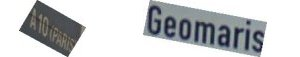

In [2]:
uid = np.random.randint(0, 15688)
# get a new ReCAPTCHA
path, context = download_reCaptcha(uid)
# show the CAPTCHA
Image(filename=path)

### ReCAPTCHA preprocessing

The text image data requires several stages of processing before it can be fed to our deep learning system. The raw reCAPTCHA image we get from Google Service consists two separate text images, which make it hard to process at once. Dark background text images are often combined with light background ones, which put an extra layer of difficulty during processing.

First, we split the image so that we can process each half individually, then converts the images into grayscale as all we only care about segmenting the text. The each image is purposely skewed, therefore the next step to recover the image to the proper angle.

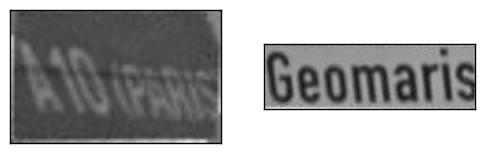

In [3]:
output_directory = os.getcwd() + "/output/"
# split the image to two halfs, deskew each one, 
# remove whitespaces and convert them to gray images
# the temporary results of each step are stored in output folder for reference
processed_grays = preprocess_raw_image(path, output_directory)
# show processed images
plot_images(processed_grays)

### Character Segmentation

Character segmentation has to be performed before feeding the data to the classifier. 
The intermediate results from last step are in grayscale. Since the ReCaptcha images are mixed with dark background ones and light background ones, the remaining white margin brings trouble when deciding the font color. Before binarization, we want to remove the white margin as much as possible. Without extra white margin, the image should contain two major colors, one for background, the other for fonts. We use kMeans with $k = 2$ to compute the center color values. We not only get the font and background colors (heuristically, characters take up less space), we can also tell whether the image is dark background or light background, which decide whether we want to invert the color when convert the image into binary. The 

Once image binarization is complete, we use DFS to find all connected components in the binary image. This has the underlying assumption that there is clear delineation better characters. Thus, we need to ensure the characters are thin. Specifically, when we convert the grayscale image to binary image with adaptive thresholding, we tune the block size with kmeans's color fraction stats. Intuitively, font color and background color each taking half of the space indicates the characters are thick; otherwise they are thin. Hence, if the characters are think, we use a small block size, as small block size can get clearer boundary but brings up more noises.

The major challenge we are facing during the preprocessing stage is how to segment a text image. We have experimented several approaches, each approach has its own advantage and disadvantage. It is possible to use a mixed strategies to improve the precision. Here we will mainly introduce two of them.

One approach is to utilize to openCV’s threshold API to convert the text image into a binary image then find the contour of each character, which helps us the construct bounding box of each character. However, this approach relies on the high contrast of the image to separate text from background, which is not always the case. Besides, as the images are mixed of dark background ones and light background ones, it becomes hard to set a threshold that works for all images. The main issue comes when the difference between text color and background are so subtle that simply apply such binary conversion would make the text blend in the background.

Another approach is to linearly scan the image. However, reCaptcha has various fonts, some are relatively round, while some are slim. For slim fonts, two characters may sit in the window, which potentially confuses the model. Also, it works for text images with a noticeable distance between characters, while sometimes there is no such space.

### Canonicalization

The width to height ratio is a critical metric to determine whether an image is a character. Usually, this ratio is close to 1, while there are extremely thin or fat characters in ReCAPTCHA. Thus, we have to set this ratio to very conservative to allow the thinnest I and fattest M to pass. Furthermore, we ignore the components with tiny size, as they are likely come from the noises. Each connected component is treated as a character, we then compute the bounding box of each component and slice the image accordingly. Finally, all characters are scaled to 28 $\times$ 28, and then they are fed into the classifer.


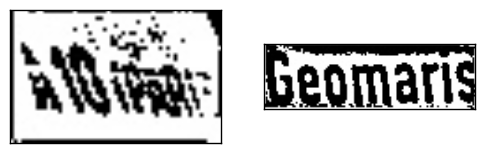

In [4]:
binary_images = []
kmeans_images = []
for gray in processed_grays:
    # kmeans with cluster = 2 to split the background and foreground
    # based on kmeans result to set hyper-parameters and
    # use adaptive thresholding to convert the gray image to binary image
    binary, kmeans = gray_to_binary(gray)
    binary_images.append(binary)
    kmeans_images.append(kmeans)
# show binary images
plot_images(binary_images)

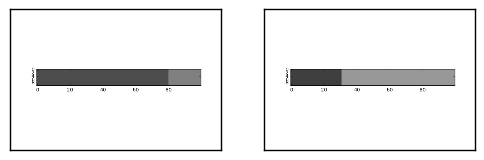

In [5]:
# show the clustering result of kmeans
plot_images(kmeans_images)

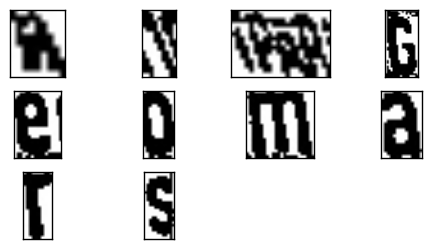

In [6]:
characters_list = []
all_characters = []
for binary in binary_images:
    # segment the binary images, and output single characters
    classified = text_to_characters(binary, output_directory)
    characters_list.append(classified)
    all_characters.extend(classified)
# show segmented characters for the first image
plot_images(all_characters)

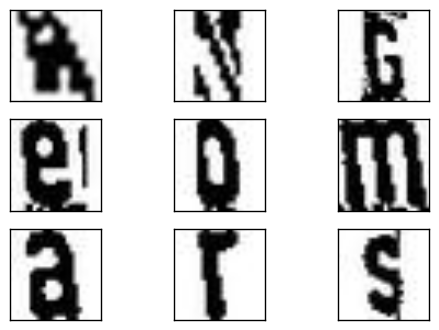

In [7]:
# filter and scale the image to 28 * 28
to_classify_list = []
filtered_chars_list = []
all_filtered_characters = []
for characters in characters_list:
    filtered_chars, to_classify = image_to_numpy_array(characters)
    to_classify_list.append(to_classify)
    filtered_chars_list.append(filtered_chars)
    all_filtered_characters.extend(filtered_chars)
# show the filtered and scaled images
plot_images(all_filtered_characters)

### Data syntheses and augmentation

The most common approach to secure training examples is to manually label some data. Recaptcha has various fonts with random scaling, translation, rotation and distortion. Assuming we need 1000 examples per class there are 36 classes, we may manually label 36000 data, which is too expensive. Thus, we design data augmentation process. Specifically, we can apply random scaling, translation, rotation and distortion, even interference lines, to all our labeled examples, as recaptcha did. By doing this, we drastically saved manual efforts.

Since we want to identify digits or letters, we even do not need to label examples at all. After examining the raw data, we could notice that there are some common fonts, including Highway Gothic, Filetto and KG Empire of Dirt. Therefore, we downloaded those fonts and generated examples using them.

Moreover, noises and overlappings are prevalent in CAPTCHA. Thus, we purposefully add overlapping and noises to the synthesized examples. 

### Convolutional neural networks

Due to imperfect segmentation and deskewing, the final character to be classfied has many distortions. Hence, we are particularly interested in an classifying algorithm that not only is robust to noises but is translation and rotation invariant. Convolutional neural networks (CNNs) have this kind of nice property. Specifically, we constructed a CNN with two convolutional layer and two max pooling layer. Also, we adopt dropout from regularization. We will also compare the performance of CNN with a fully-connected neural network in the next section.

### Evaluation

To evaluate the results, we first convert all segmented characters into numpy arrays, which are then fed into CNN. Also, we included a pretrained model, which can be directly used in classification. The results from two sub-images are concatenated using a space, which mimics the behavior of human.

Finally, we need to send this text to Google Server with all information required in one package. The text result will be sent with the challenge token we obtained during the data gathering phase as a unique identifier, and also the private key to perform authentication. In addition, remote IP address is required during the verification stage, which will be random generated. Making too many requests from the same IP address in a short time is suspicious and may lead to service blocking. The response of the request contains the verification result in plaintext.

In [8]:
# load pretrained model to classify
# the pretrained weights can be found on github
pretrained_model = "pretrained_model.w"
model = load_pretrain_model(pretrained_model)
text = ""
num_chars = len(to_classify_list)
for i in xrange(0, num_chars):
    if len(filtered_chars_list[i]) <= 2:
        # better to ignore some very blurry images
        print "Failed to segment part", i, "of the image"
        continue
    text += classify_digits(model, to_classify_list[i]) + " "
text = text.strip()
print "The final result is [", text, "]"

Failed to segment part 0 of the image
The final result is [ GEOMARS ]


In [9]:
print "Passed verification successfully" if evaluate(text, context) else "Failed to pass verification"

Passed verification successfully


## Experiment Results

### Segmentation success rate

The main bottleneck in our system is the image processing pipeline. We seldom see the CAPTCHA perfectly segmented due to the distortion and noise in the image. To solve this, we also introduce noise to our training examples. Also, we noticed that Google does not expect us to recognize some really blurry images. Thus, we will discard one part of the CAPTCHA if we are unable to segment characters from it. Interestingly, our model also works well in some specical cases. For example, even humans have to take extreme caution to recognize SASSAR from the below image, but our system made it.

[![segmentation_ex.jpg](https://s30.postimg.org/gaczvcdsx/segmentation_ex.jpg)](https://postimg.org/image/ndkvayj8d/)

### Per-character accuracy

We trained our model on about 250,000 synthesized examples, and tested on 50,000 synthesized. We achieved a per-character error rate of 2% on training set and 2.5% on test sets. This shows our model can handle this scenario well.

To better evaluate our model, we labelled 1,000 examples, and use it as our development set. CNN can achieve 82% accuracy on the dev set, while a fully-connected model can only achieve 78%. Therefore, CNN has better generalization ability, and we selected as our final model. Since the i.i.d assumption of training and test data is not satisfied, we also use early stopping, i.e. stop training once the validation accuracy begins to increase. With early stopping, the best validation accuracy is reached, when the training accuracy is 90%. 

Finally, we labelled another 1,000 examples to fine tune our model. Now, we can meet the i.i.d assumption, while the amount of examples are too small. Some classes even have no training examples. The main idea is first pretraining on the synthesized dataset with large learning rate, and then training on the labelled dataset with small learning rate. The pretraining along with dropouts serves as a strong regularizer. Using this approach, we can achieve a 94% accuracy on the test set.

[![error decomposition.png](https://s17.postimg.org/9bktahhnj/error_decomposition.png)](https://postimg.org/image/6u9237xqz/)

### End-to-end evaluation

As mentioned above, we implemented a pipeline that retrieves a reCAPTCHA, pre-processes the image, and performs character recognition by the model we trained to construct response which will then be sent back to Google. If the response passes Google authentication that means the recognition results are within Google’s fault tolerance designed for the human user.

By running the pipeline for 200 times, we found that the overall pass rate is 26%. This is decent, as parsing one ReCAPTCHA usually takes 2 seconds without any optimizatio, and 26% means we can successfully pass the check once every 8s. Assuming one ReCAPTCHA worths $0.01, our system can earn 100 dollars per day. One quad-core machine on AWS costs only 4.8 dollars. This means our system is very profitable.

[![result.png](https://s24.postimg.org/z5hoxixqt/result.png)](https://postimg.org/image/sf17o3akx/)

Finally, we also compare our model against the state-of-the-art. It is easy to notice that the accuracy of our strategy is lower than some of state-of-the-arts, but this is mainly because we are not specifically tuned to break ReCAPTCHA. Also, the main complexity in our model is the KMEANS clustering. We could classify the images faster if we use fewer iterations.

## Conclusions

In this project, we demonstrate the possibility to break any traditional CAPTCHA system by designing a general robot that has a overall pass rate of 26
%. One interesting finding is that we can break ReCAPTCHA even without labelled data, and thus it is easy to port our system to other scenarios. Finally, we can conclude that traditional CAPTCHA systems are vulnerable to attacks. This is partly why Google designed the “I’m not a robot” checkbox. However, this improvement does not make the system less vulnerable, because Google still allows robots to solve the puzzle. The only benefit of this system is to free humans from the competition with robots, as humans are less likely to have to solve a puzzle, while machines always need to solve a puzzle.

## Future work

All components in our data processing pipeline are designed to be replaceable. Thus, it is possible to dig into each module and replace them with better ones. Due to the time constraint, many components in our project are not well-tuned, e.g. try different hyper-parameters. Also, it is possible to combine several approaches to get a better result, e.g. using a mixed of kmeans and adaptive thresholding to make better decision. Moreover, many other image processing like dilation and erosion could apply to character segmentation to eliminate noise. Regarding the data syntheses module, we can also generate more examples with various kinds of noises and fonts. Finally, there are many other types of CAPTCHA, like Q&A or image selection. With popular Q&A robots and image captioning algorithms, it is also possible to break them and we would also like to test their vulnerability in the future. 

## References

[1] Cruz-Perez, C. et al. Breaking reCAPTCHAs with Unpredictable Collapse: Heuristic Character Segmentation and Recognition. MCPR. pp 155-165 (2012)

[2] Yan, J.: A low-cost attack on a Microsoft CAPTCHA. In: 15th ACM Conf. on Comp. and Com. Security, USA, pp. 543–554 (2010)

[3] Bursztein, E., Matthieu, M., John, M.: Text-based CAPTCHA Strengths and Weaknesses.
In: 18th ACM Conf. on Computer and Com. Security, Ill, USA, pp. 125–138 (2011)
